In [1]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import QpixAsic as qpasic
import random
import numpy as np
random.seed(7)

In [2]:
# make this a unit test
qpa = qparray.QpixAsicArray(2, 2, debug=0.0, timeout=1e4, deltaT=2e-6)
qpa.Calibrate(0.00025)
print(qpa._daqNode.hitData.items())
end, counts = 0, 0
while True:
    hit = qpa._daqNode._localFifo.Read()
    if hit is None:
        break
    if hit.wordType != qpasic.AsicWord.EVTEND:
        counts += 1
        print(hit, counts)
    else:
        end += 1

print(f"found daq hits: {qpa._daqNode.daqHits}")
print(f"event end: {end}")

dict_items([('(0, 0)', []), ('(0, 1)', []), ('(1, 0)', []), ('(1, 1)', [])])
(0,0): AsicWord.REGRESP  - 5.351485674359715e-06 1
(0,1): AsicWord.REGRESP  - 1.0502873696709451e-05 2
(1,0): AsicWord.REGRESP  - 1.0897923324942458e-05 3
(1,1): AsicWord.REGRESP  - 1.584918178161636e-05 4
(0,0): AsicWord.REGRESP  - 0.0002573556303356563 5
(0,1): AsicWord.REGRESP  - 0.0002624989372988958 6
(1,0): AsicWord.REGRESP  - 0.00026289606616330426 7
(1,1): AsicWord.REGRESP  - 0.00026783665269519675 8
found daq hits: 16
event end: 8


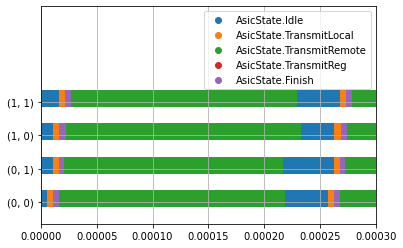

In [3]:
# unit test this based on duration of time out?
qparray.viewAsicState(qpa)

Text(0.5, 1.0, 'ASIC Frequency Error Calculation')

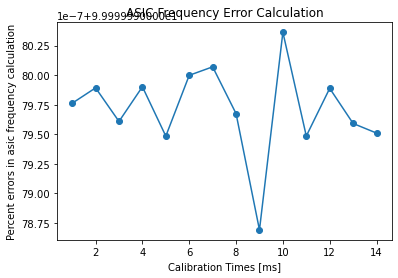

In [4]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
import numpy as np
random.seed(7) 
# investigate why some random seeds allow you to do several calibrations and others dont, maybe it is with the asic oscillation frequency?

row = 2
col = 2

GuessFreqArray = []
PercDiffArray = {}
Keys = []
CalibrateThroughTimes = np.arange(1, 15) * 1e-3
freq = {}

for number, CalTime in enumerate(CalibrateThroughTimes):
    q = qparray.QpixAsicArray(row, col, debug = 0., deltaT = 1e-6, timeEpsilon = 2e-6)
    q.Calibrate(CalTime)

    guessFrq = {}
    for k, v in q._daqNode.regData.items():
        asic = k
        daqTicks = []
        asicTicks = []
        for daqTick, Byte in v:
            daqTicks.append(daqTick)
            asicTicks.append(Byte.data) # Byte[4] or Byte.data depending what is appended
        if len(asicTicks) < 2:
            print(f'\nno work fo da calibration time {CalTime}: ')
            for asic in q:
                print(f'osc freq: {asic.fOsc}')
                print(f'start time {asic._startTime}')
                print()

        # print("asic ticks:", asicTicks)
        guessFrq[asic] = (asicTicks[-1] - asicTicks[-2]) / (daqTicks[-1] - daqTicks[-2])  * q._daqNode.fOsc
        GuessFreqArray.append(guessFrq[asic])
        # print(f'appending {guessFrq[asic]} for asic {asic}')

    for asic in q:
        key = f"({asic.row}, {asic.col})"
        if key not in Keys: Keys.append(key)
        # print(f"{key} percent diff: {(guessFrq[key] - asic.fOsc) / asic.fOsc * 100:1.2E}")
        percdiff = (guessFrq[key] - asic.fOsc) / asic.fOsc * 100
        if key not in PercDiffArray:
            PercDiffArray[key] = []
        PercDiffArray[key].append(percdiff)

#################################################
## PLOTTING

import pylab as p

plot = np.zeros((len(CalibrateThroughTimes)))
for runs in range(len(CalibrateThroughTimes)):
    somethingcreative = []
    for key in Keys:
        somethingcreative.append(np.absolute(PercDiffArray[key][runs]))
    plot[runs] = sum(somethingcreative) / len(Keys);

p.plot(CalibrateThroughTimes * 1e3, plot, linestyle='-', marker='o');
p.xlabel('Calibration Times [ms]')
p.ylabel('Percent errors in asic frequency calculation')
p.title('ASIC Frequency Error Calculation')

In [5]:
## THIS PROBLEM CAN PROBABLY SOLVED BY MESSING WITH THE TIMEOUT TIME
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
import numpy as np

row = 2
col = 2

# CalTimes = np.arange(1, 20) * 1e-3
# WorkingFreq = np.zeros((100000, 4))
# NonWorkingFreq = np.zeros((100000, 4))
# step = 0

# for j in range(1000):
#     random.seed(random.randint(0, 100000))
#     for i in CalTimes:
#         q = qparray.QpixAsicArray(row, col, debug = 0., deltaT = 1e-5, timeEpsilon = 2e-6, timeout=2000)
#         q.Interrogate(interval=i)
#         if q._alert:
#             for index, asic in enumerate(q):
#                 NonWorkingFreq[step, index] = asic.fOsc
#         else:
#             for index, asic in enumerate(q):
#                 WorkingFreq[step, index] = asic.fOsc
#         step+=1

# WorkingFreq = WorkingFreq[NonWorkingFreq[:,0] == 0]
# WorkingFreq = WorkingFreq[WorkingFreq[:, 0] > 0, 0:3] * 1e-6
# NonWorkingFreq = NonWorkingFreq[NonWorkingFreq[:, 0] > 0, 0:3] * 1e-6

# ###################################
# # PLOTTING

# fig = plt.figure(figsize=(10, 10))
# ax = plt.axes(projection='3d')
# ax.set_xlim(43, 58)
# ax.set_xlabel('asic (0, 0) frequency [MHz]')
# ax.set_ylim(43, 58)
# ax.set_ylabel('asic (0, 1) frequency [MHz]')
# ax.set_zlim(43, 58)
# ax.set_zlabel('asic (1, 0) frequency [MHz]')

# ax.plot(*WorkingFreq, marker = 'o', color = 'blue', linestyle = '');
# ax.plot(*NonWorkingFreq, marker = 'o', color = 'red', linestyle = '');
# ax.legend(('working frequency combinations', 'non-working frequency combinations'));
# leg = ax.get_legend()
# leg.legendHandles[0].set_color('blue')
# leg.legendHandles[1].set_color('red')
# plt.show()

# plt.plot(WorkingFreq[:,0], WorkingFreq[:,1], marker = 'o', color = 'blue', linestyle = '')
# plt.plot(NonWorkingFreq[:,0], NonWorkingFreq[:, 1], marker = 'o', color = 'red', linestyle = '')
# plt.xlabel('asic (0, 0) frequency [MHz]')
# plt.ylabel('asic (0, 1) frequency [MHz]')
# plt.show()

timeout 1000.0s works for an array of 1 x 1 asics
timeout 3000.0s works for an array of 2 x 1 asics
timeout 3000.0s works for an array of 2 x 2 asics
timeout 3000.0s works for an array of 3 x 2 asics
timeout 3000.0s works for an array of 3 x 3 asics
timeout 3000.0s works for an array of 4 x 3 asics
timeout 5000.0s works for an array of 4 x 4 asics
timeout 7000.0s works for an array of 5 x 4 asics
timeout 7000.0s works for an array of 5 x 5 asics
timeout 9000.0s works for an array of 6 x 5 asics


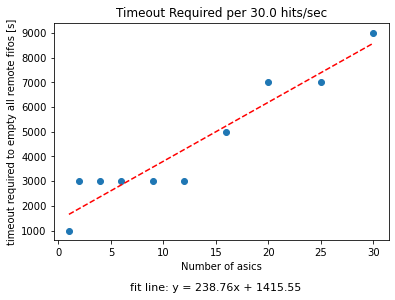

In [12]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
import numpy as np
import pylab as p
from scipy.optimize import curve_fit as cf
random.seed(7)

DIRECTIONS = ("North", "East", "South", "West")

row = 1
col = 1
iters = 10
WorkingTimeoutArray = np.zeros((iters, 2))
toggle = True
TimeoutArray = np.arange(1, 1000, 2) * 1e3

for tiledim in range(iters):

    for timeout in TimeoutArray:
        timeoutwork=0
        array = qparray.QpixAsicArray(row, col, deltaT=1e-4, timeout=timeout, hitsPerSec=30.)
        array.Interrogate(interval=.2)
        for asic in array:
            for direc in range(4):
                CurSize = asic._remoteFifos[direc]._curSize
                if CurSize > 0:
                    timeoutwork+=1
        if timeoutwork == 0:
            print(f'timeout {timeout}s works for an array of {row} x {col} asics')
            WorkingTimeoutArray[tiledim, 0] = row * col
            WorkingTimeoutArray[tiledim, 1] = timeout
            if toggle:
                row+=1
            else:
                col+=1
            toggle = not(toggle)
            break
    if timeout == TimeoutArray[-1]:
        break

xvalues = WorkingTimeoutArray[:, 0]
yvalues = WorkingTimeoutArray[:, 1]

def FitFunc(x, a, b):
    return a * x + b

popt, pcov = cf(FitFunc, xvalues, yvalues)

p.plot(xvalues, yvalues, marker='o', linestyle='')
p.plot(xvalues, FitFunc(xvalues, *popt), linestyle = '--', color = 'red')
p.title(f'Timeout Required per {array._asics[0][0].randomRate} hits/sec')
p.xlabel('Number of asics')
p.ylabel('timeout required to empty all remote fifos [s]')
txt = f'fit line: y = {popt[0]:2.2f}x + {popt[1]:2.2f}'
p.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=11);

the reg data and hit data for asic (0, 0) is 0 and 49
the reg data and hit data for asic (0, 1) is 0 and 49
the reg data and hit data for asic (0, 2) is 0 and 49
the reg data and hit data for asic (1, 0) is 0 and 49
the reg data and hit data for asic (1, 1) is 0 and 49
the reg data and hit data for asic (1, 2) is 0 and 49
the reg data and hit data for asic (2, 0) is 0 and 49
the reg data and hit data for asic (2, 1) is 0 and 49
the reg data and hit data for asic (2, 2) is 0 and 49


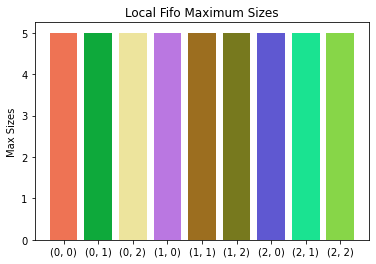

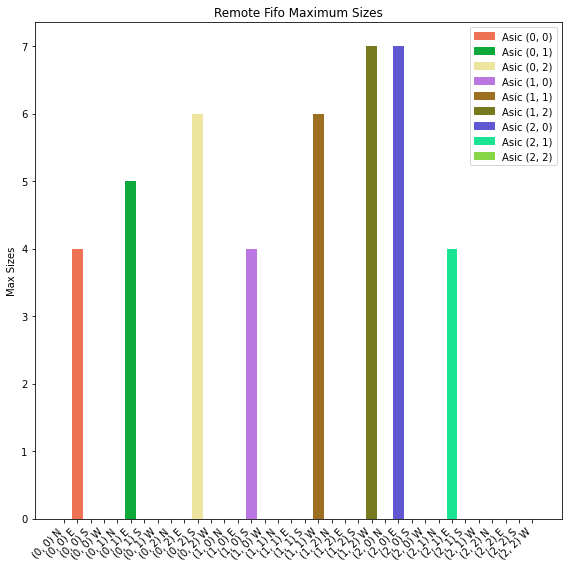

In [34]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
random.seed()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time

moveon = False
# for timeout in np.arange(0.1, 5, 0.1) * 1e4:
row = 3
col = 3
numOfAsics = row * col
array = qparray.QpixAsicArray(row, col, deltaT=1e-5, 
    timeout=timeout)

## setup
## inject hits into asics
times = np.arange(0, 5, 0.1)
channels = [[1, 7, 8]] * len(times)
for asic in array:
    asic.InjectHits(times=times, channels=channels)
array.Route('snake', timeout=timeout)
## main
t = 0
int_frq = 0.5 # interrogate every second
stop = 5.5  # 100s of data
while t < stop:
    array.Interrogate(int_frq)
    if array._alert:
        # print('timeout time is too short')
        moveon = True
    for d in range(4):
        if array[0][0]._remoteFifos[d]._curSize != 0:
            # print('timeout time is too short')
            moveon = True
    t += int_frq
    # if moveon:
    #     continue
    # else:
    #     print(f'the timeout time is {timeout}')
    #     break

for asic in array:
    key = f'({asic.row}, {asic.col})'
    print(f'the reg data and hit data for asic {key} is ', end="")
    print(len(array._daqNode.regData[key]), end=" and ")
    print(len(array._daqNode.hitData[key]))

qparray.MakeFifoBars(array)

In [35]:
# start 12:00 - 2:30
import QpixAsicArray as qparray
from QpixAsic import AsicWord
for i in array._daqNode.daqData['(0, 0)']:
    if i[1].wordType == AsicWord.EVTEND:
        print(i)
    if i[1].wordType == AsicWord.REGRESP:
        print(i)


(453500, (0,0): AsicWord.EVTEND  - None)
(25454748, (0,0): AsicWord.EVTEND  - None)
(50455248, (0,0): AsicWord.EVTEND  - None)
(75455248, (0,0): AsicWord.EVTEND  - None)
(100455248, (0,0): AsicWord.EVTEND  - None)
(125455248, (0,0): AsicWord.EVTEND  - None)
(150455248, (0,0): AsicWord.EVTEND  - None)
(175455248, (0,0): AsicWord.EVTEND  - None)
(200455248, (0,0): AsicWord.EVTEND  - None)
(225455748, (0,0): AsicWord.EVTEND  - None)
(250455998, (0,0): AsicWord.EVTEND  - None)


Determining the run time for a left routed tile
with uniformly distributed hits every 0.1s for 5s
and an interrogation frequency of 0.1s
    1x1: 1.9s
    2x2: 2.5s
    3x3: 5.8s
    4x4: 8.9s
    5x5: 14.6s
    6x6: 19.7s
    7x7: 26.5s
    8x8: 36.9s

Determining the run time for a snake routed tile
with uniformly distributed hits every 0.1s for 5s
and an interrogation frequency of 0.1s
    1x1: 1.1
    2x2: 2.6s
    3x3: 5.5s 
    4x4: 9.4s
    5x5: 14.7s
    6x6: 20.2s
    7x7: 28.5s
    8x8: 39.1

Routing method doesn't make too much of a difference in computational time



In [12]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
random.seed()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from QpixAsic import AsicConfig as aconfig
from QpixAsic import AsicDirMask as dirMask



DIRECTIONS = ("North", "East", "South", "West")
stobit = False
for spike in np.arange(0, 2000, 100):
    
    if stobit:
        break

    row = 2
    col = 2
    array = qparray.QpixAsicArray(row, col, deltaT=1e-5, 
        timeout=2e4, hitsPerSec = 1./1.)
    array.Route(timeout = 2e4)

    #inject the noise in the detectors
    times = np.arange(0, 5, 0.3)
    channels = [[1, 7, 8]] * len(times)
    for asic in array:
        asic.InjectHits(times=times, channels=channels)

    # spike of interesting event
    array[0][1].InjectHits(times=np.linspace(1,1.1,spike), channels=[[6,9]]*spike)
    array[1][1].InjectHits(times=np.linspace(3, 3.01, 200), channels = [[7, 0]] * 200)



    ## main
    t = 0
    int_frq = 100e-3
    stop = 5.5  
    while t < stop:
        array.Interrogate(int_frq)
        if array._alert:
            print('timeout time is too short')
        t += int_frq

    # qparray.MakeFifoBars(array)
    for asic in array:
        key = f'({asic.row}, {asic.col})'
        print(f'the reg data and hit data for asic {key} is ', end="")
        print(len(array._daqNode.regData[key]), end=" and ")
        print(len(array._daqNode.hitData[key]), end=" \n")
        for d in range(4):
            if asic._remoteFifos[d]._full:
                print(f'{key} remote fifo in {DIRECTIONS[d]} was full')
                stobit = True
        if asic._localFifo._full:
            print(f'{key} local fifo was full')
            stobit = True

the reg data and hit data for asic (0, 0) is 0 and 16 
the reg data and hit data for asic (0, 1) is 0 and 16 
the reg data and hit data for asic (1, 0) is 0 and 16 
the reg data and hit data for asic (1, 1) is 0 and 216 
the reg data and hit data for asic (0, 0) is 0 and 16 
the reg data and hit data for asic (0, 1) is 0 and 116 
the reg data and hit data for asic (1, 0) is 0 and 16 
the reg data and hit data for asic (1, 1) is 0 and 216 


KeyboardInterrupt: 

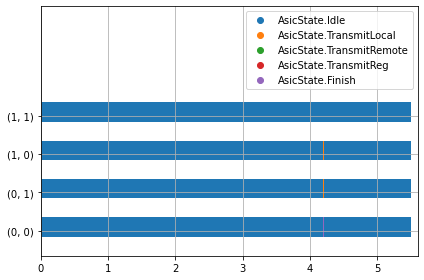

In [3]:
import QpixAsicArray as qparray
qparray.viewAsicState(array, time_begin=0, time_end=array._timeNow)

In [9]:
random.seed(7)

times = [4, 9, 8,2,4,5,1,6]

pixels = []
[pixels.append([]) for i in range(len(times))]
for i in range(len(times)):
    NumOfChan = int(np.absolute(np.ceil(random.gauss(1.5, 2))))
    for channels in range(NumOfChan):
        pixels[i].append(random.randint(0, 16))
print(f'times is {times}')
print(f'pixels is {pixels}')

timesextendo = [0, 1, 2, 3]
times.extend(timesextendo)
pixectendo = [[1, 7, 8]] * len(timesextendo)
pixels.extend(pixectendo)

times, pixels = zip(*sorted(zip(times, pixels)))
times = [*times]
pixels = [*pixels]
print(times)
print(pixels)

times is [4, 9, 8, 2, 4, 5, 1, 6]
pixels is [[1], [2, 3, 11], [6, 1], [], [7, 2, 13, 1], [3, 7, 1], [], [7]]
[0, 1, 1, 2, 2, 3, 4, 4, 5, 6, 8, 9]
[[1, 7, 8], [], [1, 7, 8], [], [1, 7, 8], [1, 7, 8], [1], [7, 2, 13, 1], [3, 7, 1], [7], [6, 1], [2, 3, 11]]
